In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.integrate as integrate
import math
from scipy.stats.distributions import norm
from scipy.stats import gamma
import sobol_seq
import ghalton
from scipy import stats
from pyDOE import *
%matplotlib inline

In [3]:
def ADRSource(Lx, Nx, Source, omega, v, kappa):
    #Solves the diffusion equation with Generalized Source
    A = sparse.dia_matrix((Nx,Nx),dtype="complex")
    dx = Lx/Nx
    i2dx2 = 1.0/(dx*dx)
    #fill diagonal of A
    A.setdiag(2*i2dx2*omega + np.sign(v)*v/dx + kappa)
    #fill off diagonals of A
    A.setdiag(-i2dx2*omega[1:Nx] + 
              0.5*(1-np.sign(v[1:Nx]))*v[1:Nx]/dx,1)
    A.setdiag(-i2dx2*omega[0:(Nx-1)] - 
              0.5*(np.sign(v[0:(Nx-1)])+1)*v[0:(Nx-1)]/dx,-1)
    #solve A x = Source
    Solution = linalg.spsolve(A.tocsr(),Source)
    Q = integrate.trapz(Solution*kappa,dx=dx)
    return Solution, Q

[ 10.  10.  10. ...,  10.  10.  10.]
(52.3902529277+0j)


/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


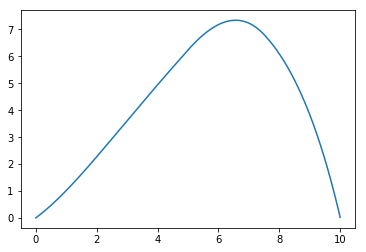

In [4]:
Lx = 10
Nx = 2000
dx = Lx/Nx
Source_func = lambda x, q:  q*x*(10-x)
kappa_func = lambda x, kappal, kappah: kappah + (kappal-kappah)*(x>5)*(x<7.5)
v_func = lambda x,v: v*np.ones(x.size)
omega_func = lambda x,omega: omega*np.ones(x.size)

#nominal values

import csv

xs = np.linspace(dx/2,Lx-dx/2,Nx)
source = Source_func(xs, 1)
kappa = kappa_func(xs, 0.1, 2)

omega_nom = 20
omega_var = 0.3195214
v_nom = 10
v_var = 0.0723493
kappal_nom = 0.1
kappal_var = 8.511570e-6
kappah_nom = 2
kappah_var = 0.002778142
q_nom = 1
q_var = 7.062353e-4
vs = v_func(xs, v_nom)
print(vs)
sol,Q = ADRSource(Lx, Nx, source, omega_func(xs, omega_nom), vs, kappa)
print(Q)
plt.plot(xs,sol)
plt.show()

We are going to join gamma RVs with a normal copula. First we get the normal samples

In [5]:
means = [v_nom, omega_nom, kappal_nom, kappah_nom, q_nom]
varmat = np.zeros((5,5))
#fill in diagonal
corrmat = np.ones((5,5))
corrmat[0,:] = (1,.1,-0.05,0,0)
corrmat[1,:] = (.1,1,-.4,.3,.5)
corrmat[2,:] = (-0.05,-.4,1,.2,0)
corrmat[3,:] = (0,.3,0.2,1,-.1)
corrmat[4,:] = (0,.5,0,-.1,1)
print(corrmat-corrmat.transpose())
print(corrmat)


varmat[np.diag_indices(5)] = [v_var, omega_var, kappal_var, kappah_var, q_var]
for i in range(5):
    for j in range(5):
        varmat[i,j] = math.sqrt(varmat[i,i])*math.sqrt(varmat[j,j])*corrmat[i,j]
print(varmat)
print(varmat-varmat.transpose())
print(np.linalg.eig(varmat))

samps = 10**6 #4*10**4
test = norm.cdf(np.random.multivariate_normal(np.zeros(5), corrmat, samps))

print(np.max(test[:,0]))
import tabulate
#print(tabulate.tabulate(corrmat, tablefmt="latex", floatfmt=".2f"))

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 1.    0.1  -0.05  0.    0.  ]
 [ 0.1   1.   -0.4   0.3   0.5 ]
 [-0.05 -0.4   1.    0.2   0.  ]
 [ 0.    0.3   0.2   1.   -0.1 ]
 [ 0.    0.5   0.   -0.1   1.  ]]
[[  7.23493000e-02   1.52043249e-02  -3.92366580e-05   0.00000000e+00
    0.00000000e+00]
 [  1.52043249e-02   3.19521400e-01  -6.59651879e-04   8.93816670e-03
    7.51094687e-03]
 [ -3.92366580e-05  -6.59651879e-04   8.51157000e-06   3.07547395e-05
    0.00000000e+00]
 [  0.00000000e+00   8.93816670e-03   3.07547395e-05   2.77814200e-03
   -1.40072194e-04]
 [  0.00000000e+00   7.51094687e-03   0.00000000e+00  -1.40072194e-04
    7.06235300e-04]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
(array([  3.20880078e-01,   7.14248146e-02,   2.58516363e-03,
         4.68396801e-04,   5.13602871e-06]), array([[ -6.10221850e-02,  -9.98104846e-01, 

The distributions will be gammas

In [9]:

def gen_samps(samps,test):
    #v will have v_nom = 10 v_var = 1 which makes alpha = 10 beta = 10 or theta = 1/10
    vsamps = gamma.ppf(test[:,0], a = 100, scale = 1/10)
    #print(np.mean(vsamps), np.var(vsamps), np.std(vsamps))
    #plt.hist(vsamps)

    #omega will have  omega_nom = 20, var = 4 which makes alpha = 100 beta = 5, theta = 1/5
    omegasamps = gamma.ppf(test[:,1], a = 100, scale = 1/5)
    #print(np.mean(omegasamps), np.var(omegasamps), np.std(omegasamps))
    #plt.hist(omegasamps)

    #kappa_l will have kappa_l = 0.1 var = (0.01)^2 this makes alpha = 100 and theta = 1/1000
    kappalsamps = gamma.ppf(test[:,2], a = 100, scale = 1/1000)
    #print(np.mean(kappalsamps), np.var(kappalsamps), np.std(kappalsamps))
    #plt.hist(kappalsamps)

    #kappa_h will have kappa_h = 2 var = .04 this makes alpha = 100 and theta = 1/50
    kappahsamps = (test[:,3]>0.005)*(1.98582-4.82135) + (4.82135) # #gamma.ppf(test[:,3], a = 100, scale = 1/50)
    print(np.mean(kappahsamps), np.var(kappahsamps), np.std(kappahsamps))
    #plt.hist(kappahsamps)

    #q will have q = 1 var = 0.01 this makes alpha = 100 and theta = 1/100
    qsamps = gamma.ppf(test[:,4], a = 100, scale = 1/100)
    #print(np.mean(qsamps), np.var(qsamps),np.std(qsamps))
    #plt.hist(qsamps)
    
    return vsamps,omegasamps,kappalsamps,kappahsamps,qsamps
vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test)

var_list = [vsamps,omegasamps,kappalsamps,kappahsamps,qsamps]
cormat_emp = np.zeros((5,5))
tmp = np.vstack((var_list[0],var_list[1],var_list[2],var_list[3],var_list[4]))
cormat_emp = np.cov(tmp)
sens = np.array([-1.74063875491,-0.970393472244,13.1587256647,17.7516305655,52.3902556893])
print(cormat_emp, np.dot(sens,np.dot(cormat_emp,sens)))

2.00003451189 0.0401036225512 0.200258888819
[[  9.98436261e-01   2.01909601e-01  -4.93357130e-04   1.89174691e-05
    1.46853829e-04]
 [  2.01909601e-01   4.00334326e+00  -8.01891698e-03  -2.36925572e-02
    9.97209871e-02]
 [ -4.93357130e-04  -8.01891698e-03   1.00105004e-04  -7.63453535e-05
   -7.54351493e-07]
 [  1.89174691e-05  -2.36925572e-02  -7.63453535e-05   4.01036627e-02
    4.36026353e-04]
 [  1.46853829e-04   9.97209871e-02  -7.54351493e-07   4.36026353e-04
    9.97909527e-03]] 39.1723523081


In [56]:
Qs = np.zeros(samps)
print(np.mean(vsamps),np.mean(omegasamps),np.mean(kappalsamps), np.mean(kappahsamps),np.mean(qsamps))
for i in range(samps):
    sol,Qs[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                          kappa_func(xs, kappalsamps[i], kappahsamps[i]))


9.99852840869 19.9960102428 0.100002576294 1.99986721562 0.999848879056


/Users/ryanmcclarren/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


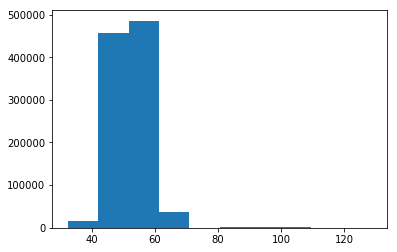

52.3116853999 60.8316865043 44.2234573396 5.75317549669 14.017206375344369 1.9879424202549845


In [57]:
plt.hist(kappahsamps)
plt.show()
plt.hist(Qs)
plt.show()
print(np.mean(Qs),stats.scoreatpercentile(Qs,95) ,stats.scoreatpercentile(Qs,5),np.std(Qs), stats.kurtosis(Qs), stats.skew(Qs))
Qref = Qs.copy()
np.savetxt(fname="ref_"+ str(samps) + "_binomial.csv", delimiter=",", X=Qref)

Now we will do 100 samples and compare

In [66]:
samps = 100 #4*10**4
test = norm.cdf(np.random.multivariate_normal(np.zeros(5), corrmat, samps))
vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test)

10.048899688 1.05332680442 1.02631710714
20.1888999669 3.56723792132 1.88871329781
0.100944499834 8.91809480331e-05 0.00944356648905
2.01888999669 0.0356723792132 0.188871329781
1.00944499834 0.00891809480331 0.0944356648905


In [67]:
QSRS = np.zeros(samps)
for i in range(samps):
    sol,QSRS[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                          kappa_func(xs, kappalsamps[i], kappahsamps[i]))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


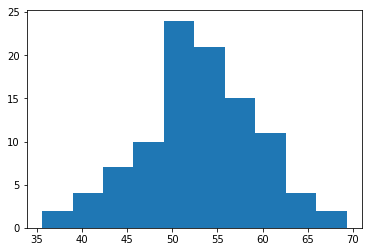

52.9925064387 62.8615331937 42.014442602 6.45412180775 0.1637176761290382 -0.0672420799462157


In [68]:
plt.hist(QSRS)
plt.show()
print(np.mean(QSRS),stats.scoreatpercentile(QSRS,95),stats.scoreatpercentile(QSRS,5),np.std(QSRS), 
      stats.kurtosis(QSRS), stats.skew(QSRS))


# LHS

In [128]:
#lhd will have the values in 0 to 1
lhd = lhs(5, samples=samps)
#now i need to turn these into samples from N(0,Corrmat)
#do cholesky fact
chol = np.linalg.cholesky(corrmat)

lhs_unif = np.zeros((samps,5))
for i in range(samps):
    lhs_unif[i,:] = np.dot(chol,norm.ppf(lhd[i,:]))
#print(lhs_unif)
#plt.plot(lhd[:,0],lhd[:,1],'.')
#plt.show()
#plt.plot(lhs_unif[:,0],lhs_unif[:,1],'.')
#plt.show()

In [70]:
test_lhs = norm.cdf(lhs_unif)

vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test_lhs)

9.99702025714 0.987923003544 0.993943159111
20.0086183567 4.01325784595 2.00331171962
0.100043091784 0.000100331446149 0.0100165585981
2.00086183567 0.0401325784595 0.200331171962
1.00043091784 0.0100331446149 0.100165585981


In [71]:
QLHS = np.zeros(samps)
for i in range(samps):
    sol,QLHS[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                          kappa_func(xs, kappalsamps[i], kappahsamps[i]))
plt.hist(QLHS)
plt.show()
print(np.mean(QLHS),stats.scoreatpercentile(QLHS,95),stats.scoreatpercentile(QLHS,5),np.std(QLHS), 
      stats.kurtosis(QLHS), stats.skew(QLHS))
print(np.mean(Qs),stats.scoreatpercentile(Qs,95) ,stats.scoreatpercentile(Qs,5),np.std(Qs), stats.kurtosis(Qs), stats.skew(Qs))




/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


52.457906306 64.0905989941 41.7991442094 7.00006039505 0.0007050930117893373 0.19082183144227305
52.409505308 64.2167045698 41.22812469 6.9968480842 0.05919686560109039 0.19809003149710752


# QMC

In [141]:
skip = round(np.log(samps)/np.log(2))
print(skip)
sobol_qmc = sobol_seq.i4_sobol_generate(5,samps, skip = 2**skip)
#now i need to turn these into samples from N(0,Corrmat)

sobol_unif = np.zeros((samps,5))
for i in range(samps):
    sobol_unif[i,:] = np.dot(chol,norm.ppf(sobol_qmc[i,:]))
#print(lhs_unif)
#plt.plot(sobol_qmc[:,0],sobol_qmc[:,1],'.')
#plt.show()
#plt.plot(sobol_unif[:,0],sobol_unif[:,1],'.')
#plt.show()

10.0


9.99444404117 0.918129187096 0.958190579737
20.0098519752 3.66910148077 1.9154898801
0.100049259876 9.17275370193e-05 0.00957744940051
2.00098519752 0.0366910148077 0.19154898801
1.00049259876 0.00917275370193 0.0957744940051


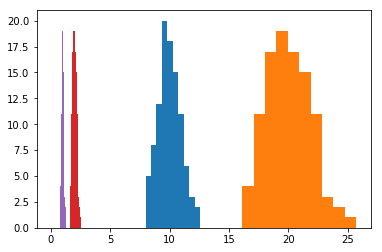

In [73]:
test_sobol = norm.cdf(sobol_unif)

vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test_sobol)

In [74]:
QSobol = np.zeros(samps)
for i in range(samps):
    sol,QSobol[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                          kappa_func(xs, kappalsamps[i], kappahsamps[i]))
plt.hist(QSobol)
plt.show()
print(np.mean(QSobol),stats.scoreatpercentile(QSobol,95),stats.scoreatpercentile(QSobol,5),np.std(QSobol), 
      stats.kurtosis(QSobol), stats.skew(QSobol))
print(np.mean(Qs),stats.scoreatpercentile(Qs,95) ,stats.scoreatpercentile(Qs,5),np.std(Qs), stats.kurtosis(Qs), stats.skew(Qs))





/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


52.4637016093 64.4392819698 41.8694246642 6.67577283494 -0.40056229654652586 0.1786591144529924
52.409505308 64.2167045698 41.22812469 6.9968480842 0.05919686560109039 0.19809003149710752


9.95604351545 0.922370683731 0.960401313895
19.8928365967 3.6660940417 1.91470468786
0.0994641829833 9.16523510425e-05 0.00957352343928
1.98928365967 0.036660940417 0.191470468786
0.994641829833 0.00916523510425 0.0957352343928


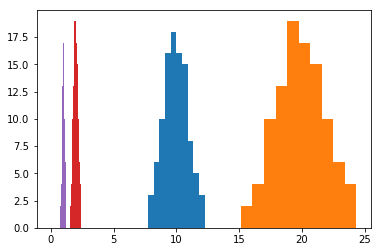

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


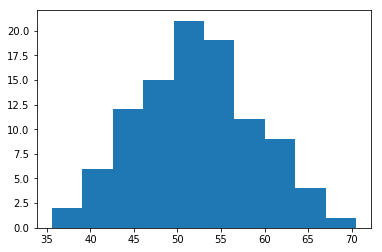

52.1252216303 63.0997893593 41.276823041 6.78764520965 -0.19452199848208807 0.06772206343014076
52.409505308 64.2167045698 41.22812469 6.9968480842 0.05919686560109039 0.19809003149710752


In [91]:
halton_des = (np.array(ghalton.Halton(5).get(100)))
halton_unif = np.zeros((samps,5))
for i in range(samps):
    halton_unif[i,:] = np.dot(chol,norm.ppf(halton_des[i,:]))

test_halton = norm.cdf(halton_unif)
vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test_halton)
plt.show()
Qhalton = np.zeros(samps)
for i in range(samps):
    sol,Qhalton[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                          kappa_func(xs, kappalsamps[i], kappahsamps[i]))
plt.hist(Qhalton)
plt.show()
print(np.mean(Qhalton),stats.scoreatpercentile(Qhalton,95),stats.scoreatpercentile(Qhalton,5),np.std(Qhalton), 
      stats.kurtosis(Qhalton), stats.skew(Qhalton))
print(np.mean(Qs),stats.scoreatpercentile(Qs,95) ,stats.scoreatpercentile(Qs,5),np.std(Qs), stats.kurtosis(Qs), stats.skew(Qs))







# OA

9.99234034775 0.951681205216 0.975541493334
20.0148035108 3.95772936303 1.9894042734
0.100074017554 9.89432340757e-05 0.00994702136701
2.00148035108 0.0395772936303 0.19894042734
1.00074017554 0.00989432340757 0.0994702136701


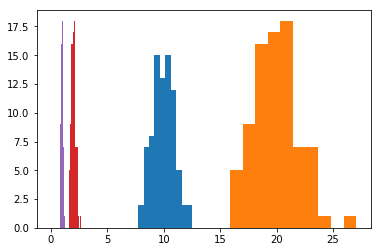

In [92]:
des9 = np.loadtxt("oa9.csv",delimiter=',')

oa_unif = np.zeros((min((samps,des9[:,0].size)),5))
for i in range((min((samps,des9[:,0].size)))):
    oa_unif[i,:] = np.dot(chol,norm.ppf(des9[i,:]))

test_oa9 = norm.cdf(oa_unif)
vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(min((samps,des9[:,0].size)),test_oa9)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


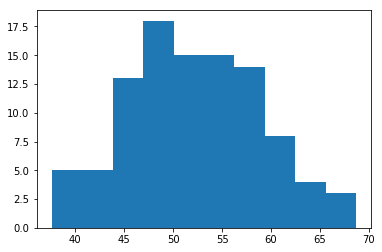

52.4637016093 63.4412117964 40.7058789981 6.92242974502 0.5012100464831777 0.3403483683276269
52.409505308 64.2167045698 41.22812469 6.9968480842 0.05919686560109039 0.19809003149710752


In [93]:
Qoa9 = np.zeros(min((samps,des9[:,0].size)))
for i in range(min((samps,des9[:,0].size))):
    sol,Qoa9[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                          kappa_func(xs, kappalsamps[i], kappahsamps[i]))
plt.hist(QSobol)
plt.show()
print(np.mean(QSobol),stats.scoreatpercentile(Qoa9,95),stats.scoreatpercentile(Qoa9,5),np.std(Qoa9), 
      stats.kurtosis(Qoa9), stats.skew(Qoa9))
print(np.mean(Qs),stats.scoreatpercentile(Qs,95) ,stats.scoreatpercentile(Qs,5),np.std(Qs), stats.kurtosis(Qs), stats.skew(Qs))






# Set up convergence 

In [186]:
def compute_vals(samps, vsamps,omegasamps,kappalsamps,kappahsamps,qsamps):
    Q = np.zeros(samps)
    for i in range(samps):
        sol,Q[i] = ADRSource(Lx, Nx, Source_func(xs, qsamps[i]), omega_func(xs, omegasamps[i]), v_func(xs, vsamps[i]),
                                kappa_func(xs, kappalsamps[i], kappahsamps[i]))
    return Q #, np.mean(Q),stats.scoreatpercentile(Q,95),stats.scoreatpercentile(Q,5),np.std(Q), stats.kurtosis(Q), stats.skew(Q)
Nsamps = [10**4,10**5] #100,400,800,1000] #
reps = 1
count = 0
for samps in Nsamps:
    for i in range(reps):
        test = norm.cdf(np.random.multivariate_normal(np.zeros(5), corrmat, samps))
        #print(len(test))
        vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test)
        #plt.plot(vsamps)
        Qsrs = compute_vals(samps,vsamps,omegasamps,kappalsamps,kappahsamps,qsamps)
        np.savetxt(fname="srs_"+ str(samps) + ".csv", delimiter=",", 
                   X=np.stack((Qsrs,vsamps,omegasamps,kappalsamps,kappahsamps,qsamps),axis=-1))
        #lhs
        lhd = lhs(5, samples=samps)
        #now i need to turn these into samples from N(0,Corrmat)
        #do cholesky fact

        lhs_unif = np.zeros((samps,5))
        for j in range(samps):
            lhs_unif[j,:] = np.dot(chol,norm.ppf(lhd[j,:]))
        test_lhs = norm.cdf(lhs_unif)

        vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test_lhs)
        Qlhs = compute_vals(samps,vsamps,omegasamps,kappalsamps,kappahsamps,qsamps)
        np.savetxt(fname="lhs_"+ str(samps) + ".csv", delimiter=",", 
                   X=np.stack((Qlhs,vsamps,omegasamps,kappalsamps,kappahsamps,qsamps),axis=-1))
    skip = round(np.log(samps)/np.log(2))
    #print(skip)
    sobol_qmc = sobol_seq.i4_sobol_generate(5,samps, skip = 2**skip)
    #now i need to turn these into samples from N(0,Corrmat)

    sobol_unif = np.zeros((samps,5))
    for i in range(samps):
        sobol_unif[i,:] = np.dot(chol,norm.ppf(sobol_qmc[i,:]))
    test_sobol = norm.cdf(sobol_unif)

    vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test_sobol)
    Q_sobol = compute_vals(samps,vsamps,omegasamps,kappalsamps,kappahsamps,qsamps)
    np.savetxt(fname="sobol_"+ str(samps) + ".csv", delimiter=",", 
               X=np.stack((Q_sobol,vsamps,omegasamps,kappalsamps,kappahsamps,qsamps),axis=-1))
    
    halton_des = (np.array(ghalton.Halton(5).get(samps)))
    halton_unif = np.zeros((samps,5))
    for i in range(samps):
        halton_unif[i,:] = np.dot(chol,norm.ppf(halton_des[i,:]))

    test_halton = norm.cdf(halton_unif)
    vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test_halton)
    Q_halton = compute_vals(samps,vsamps,omegasamps,kappalsamps,kappahsamps,qsamps)
    np.savetxt(fname="halton_"+ str(samps) + ".csv", delimiter=",", 
               X=np.stack((Q_halton,vsamps,omegasamps,kappalsamps,kappahsamps,qsamps),axis=-1))
    

    
    count += 1
    
assert 0
for samps in [100000]:
    des9 = np.loadtxt("oa9_"+str(samps) +".csv",delimiter=',')    
    oa_unif = np.zeros((min((samps,des9[:,0].size)),5))
    for i in range((min((samps,des9[:,0].size)))):
        oa_unif[i,:] = np.dot(chol,norm.ppf(des9[i,:]))

    test_oa9 = norm.cdf(oa_unif)
    vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(min((samps,des9[:,0].size)),test_oa9)
    Q_Oa = compute_vals(samps,vsamps,omegasamps,kappalsamps,kappahsamps,qsamps)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


AssertionError: 

In [185]:
samps = 10**6
lhd = lhs(5, samples=samps)
lhs_unif = np.zeros((samps,5))
for j in range(samps):
    lhs_unif[j,:] = np.dot(chol,norm.ppf(lhd[j,:]))
test_lhs = norm.cdf(lhs_unif)
vsamps,omegasamps,kappalsamps,kappahsamps,qsamps = gen_samps(samps,test_lhs)
ref_sol = compute_vals(samps,vsamps,omegasamps,kappalsamps,kappahsamps,qsamps)

np.savetxt(fname="ref_"+ str(samps) + ".csv", delimiter=",", 
           X=np.stack((ref_sol,vsamps,omegasamps,kappalsamps,kappahsamps,qsamps),axis=-1))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


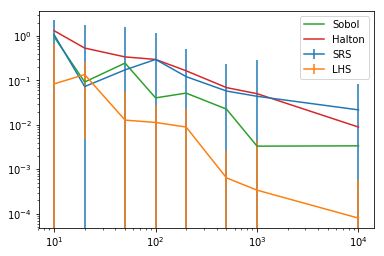

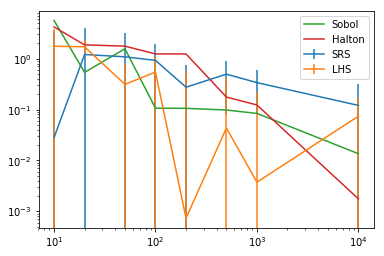

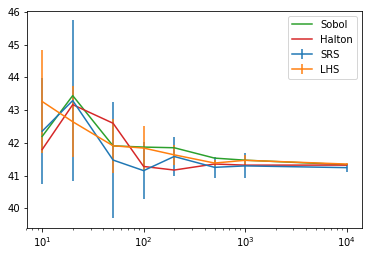

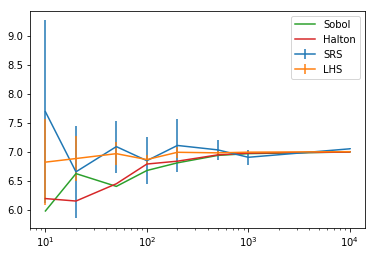

In [173]:
means = np.zeros(len(Nsamps))
mean_sds = np.zeros(len(Nsamps))
mean_lhs = np.zeros(len(Nsamps))
mean_lhs_sds = np.zeros(len(Nsamps))

m_srs_95 = np.zeros(len(Nsamps))
sd_srs_95 = np.zeros(len(Nsamps))
m_lhs_95 = np.zeros(len(Nsamps))
sd_lhs_95 = np.zeros(len(Nsamps))

m_srs_5 = np.zeros(len(Nsamps))
sd_srs_5 = np.zeros(len(Nsamps))
m_lhs_5 = np.zeros(len(Nsamps))
sd_lhs_5 = np.zeros(len(Nsamps))

m_srs_sd = np.zeros(len(Nsamps))
sd_srs_sd = np.zeros(len(Nsamps))
m_lhs_sd = np.zeros(len(Nsamps))
sd_lhs_sd = np.zeros(len(Nsamps))
#print(srs_mean)
for i in range(len(Nsamps)):
    means[i] = np.mean(srs_mean[i,:])
    mean_sds[i] = np.std(srs_mean[i,:])
    mean_lhs[i] = np.mean(lhs_mean[i,:])
    mean_lhs_sds[i] = np.std(lhs_mean[i,:])
    m_srs_95[i] = np.mean(srs_95[i,:])
    sd_srs_95[i] = np.std(srs_95[i,:])
    m_lhs_95[i] = np.mean(lhs_95[i,:])
    sd_lhs_95[i] = np.std(lhs_95[i,:])
    m_srs_5[i] = np.mean(srs_5[i,:])
    sd_srs_5[i] = np.std(srs_5[i,:])
    m_lhs_5[i] = np.mean(lhs_5[i,:])
    sd_lhs_5[i] = np.std(lhs_5[i,:])
    m_srs_sd[i] = np.mean(srs_sd[i,:])
    sd_srs_sd[i] = np.std(srs_sd[i,:])
    m_lhs_sd[i] = np.mean(lhs_sd[i,:])
    sd_lhs_sd[i] = np.std(lhs_sd[i,:])
plt.errorbar(Nsamps,np.abs(means-ref_sol[0]*np.ones(len(Nsamps))), yerr=mean_sds, label="SRS")
plt.errorbar(Nsamps, np.abs(mean_lhs-ref_sol[0]*np.ones(len(Nsamps))), yerr=mean_lhs_sds, label="LHS")
plt.plot(Nsamps,np.abs(sobol_mean-ref_sol[0]*np.ones(len(Nsamps))),label="Sobol")
plt.plot(Nsamps,np.abs(halton_mean-ref_sol[0]*np.ones(len(Nsamps))), label="Halton")
plt.legend(loc="best")
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.show()

plt.errorbar(Nsamps,np.abs(m_srs_95-ref_sol[1]*np.ones(len(Nsamps))), yerr=sd_srs_95, label="SRS")
plt.errorbar(Nsamps, np.abs(m_lhs_95-ref_sol[1]*np.ones(len(Nsamps))), yerr=sd_lhs_95, label="LHS")
plt.plot(Nsamps,np.abs(sobol_95-ref_sol[1]*np.ones(len(Nsamps))),label="Sobol")
plt.plot(Nsamps,np.abs(halton_95-ref_sol[1]*np.ones(len(Nsamps))), label="Halton")
plt.legend(loc="best")
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.show()

plt.errorbar(Nsamps,m_srs_5, yerr=sd_srs_5, label="SRS")
plt.errorbar(Nsamps, m_lhs_5, yerr=sd_lhs_5, label="LHS")
plt.plot(Nsamps,sobol_5,label="Sobol")
plt.plot(Nsamps,halton_5, label="Halton")
plt.legend(loc="best")
plt.xscale("log", nonposx='clip')
plt.show()

plt.errorbar(Nsamps,m_srs_sd, yerr=sd_srs_sd, label="SRS")
plt.errorbar(Nsamps, m_lhs_sd, yerr=sd_lhs_sd, label="LHS")
plt.plot(Nsamps,sobol_sd,label="Sobol")
plt.plot(Nsamps,halton_sd, label="Halton")
plt.legend(loc="best")
plt.xscale("log", nonposx='clip')
plt.show()

In [180]:
np.stack((Q_halton,vsamps,omegasamps,kappalsamps,kappahsamps,qsamps),axis=-1)

array([[ 49.27643609,   9.96668649,  19.09010153,   0.09545051,
          1.90901015,   0.95450508],
       [ 55.92226553,   9.30858338,  20.66292402,   0.10331462,
          2.0662924 ,   1.0331462 ],
       [ 43.41096747,  10.65510925,  17.7305328 ,   0.08865266,
          1.77305328,   0.88652664],
       ..., 
       [ 65.79282315,   9.72934348,  23.69214381,   0.11846072,
          2.36921438,   1.18460719],
       [ 36.85471159,  11.3343309 ,  16.11615227,   0.08058076,
          1.61161523,   0.80580761],
       [ 50.84786073,   8.70314223,  18.90856277,   0.09454281,
          1.89085628,   0.94542814]])